In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Evolution of r_int in the F4 run

r_int is the radius of the interface at which the relative [A(t) - A0(t)]/A0(t) with respect to a reference value A0(t) exceeds a threshold. The reference value A0(t) is taken to be the average A at a reference radius r_ref at time t. We need to put r_ref to the bottom of the convection zone, because most of the convection zone is heated in the final explosion. The threshold should be a few times larger than the typical bucket-to-bucket fluctuations in A due to convection. A value of 1e-3 is a good trade-off between sensitivity and the amount of noise.

In [2]:
import os
import sys
sys.path.insert(0, '/rpod2/home/andrassy/notebooks/lib/lcse')
import ppm
import rprofile as rprofile
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib nbagg

yprof = ppm.yprofile('/rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/F4/')
rp_set = rprofile.rprofile_set('/rpod2/PPM/RProfiles/AGBTP_M2.0Z1.e-5/F4/')

cb = utils.colourblind
gamma = 5./3.

/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Reading attributes from file  YProfile-01-1959.bobaaa
Analyzing headers ...
There are 1960 YProfile files in the /rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/F4/ directory.
Ndump values range from 0 to 1959
Time values range from 86.5493 to 162264.0


In [3]:
rp = rp_set.get_dump(rp_set.dumps[0])
n_buckets = rp.get('nbuckets')
r = rp.get('y')
r_ref = 13.
idx_ref = np.argmin(np.abs(r - r_ref))

sparse = 10
dumps = np.arange(1, 1960, sparse)
nd = len(dumps)

dr = r[1] - r[0]
r_int = np.zeros((nd, n_buckets))
avg_r_int = np.zeros(nd)
sigmap_r_int = np.zeros(nd)
sigmam_r_int = np.zeros(nd)
t = np.zeros(nd)
for i in range(nd):
    t[i] = yprof.get('t', fname=dumps[i] - 1)[-1]
    rp = rp_set.get_dump(dumps[i])
    p = rp.get_table('p')[0, :, :]
    rho = rp.get_table('rho')[0, :, :]
    A = p/rho**gamma
    A0 = A[idx_ref, 0]
    
    for bucket in range(1, n_buckets + 1):
        rel_diff = (A[:, bucket] - A0)/A0
        
        threshold = 1e-3
        # 0-th order estimate first
        idx_top = np.argmax(rel_diff > threshold)
        r_int[i, bucket - 1] = r[idx_top]
        
        # refine to 1-st order now
        slope = (rel_diff[idx_top] - rel_diff[idx_top - 1])/dr
        r_int[i, bucket - 1] -= (rel_diff[idx_top] - threshold)/slope
        
    avg_r_int[i] = np.sum(r_int[i, :])/float(n_buckets)
    dev = np.array([r_int[i, b] - avg_r_int[i] for b in range(n_buckets)])
    devp = dev[dev >= 0]
    if len(devp) > 0:
        sigmap_r_int[i] = (sum(devp**2)/float(len(devp)))**0.5
    else:
        sigmap_r_int[i] = None

    devm = dev[dev <= 0]
    if len(devm) > 0:
        sigmam_r_int[i] = (sum(devm**2)/float(len(devm)))**0.5
    else:
        sigmam_r_int[i] = None

/npod1/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide
/npod1/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater


Sparsity is 10.
r_ref = 13.000 Mm
threshold = 1.000e-03


<IPython.core.display.Javascript object>


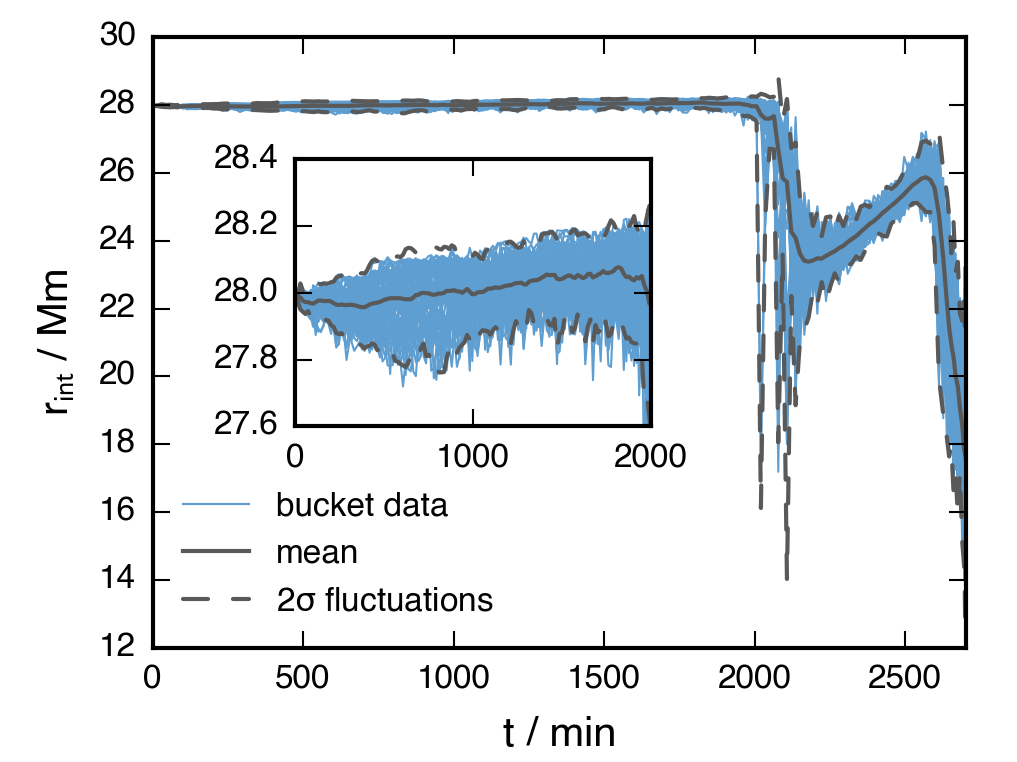

In [4]:
print 'Sparsity is {:d}.'.format(sparse)
print 'r_ref = {:.3f} Mm'.format(r_ref)
print 'threshold = {:.3e}'.format(threshold)

def plot_data(ax):
    for i in range(n_buckets):
        lbl=''
        if i == 0:
            lbl='bucket data'
        ax.plot(t/60., r_int[:, i], '-', lw=0.5, color=cb(3), label=lbl)
    
    ax.plot(t/60., avg_r_int, '-', lw=1.0, color=cb(4), label='mean')
    ax.plot(t/60., avg_r_int + 2*sigmap_r_int, '--', lw=1., color=cb(4), \
             label = r'2$\sigma$ fluctuations')
    ax.plot(t/60., avg_r_int - 2*sigmam_r_int, '--', lw=1., color=cb(4))

ifig = 1; plt.close(ifig); fig = plt.figure(ifig)
ax1 = fig.add_subplot(111)
plot_data(ax1)
ax1.set_xlim((0., t[-1]/60))
ax1.set_ylim((12., 30.))
ax1.set_xlabel('t / min')
ax1.set_ylabel(r'r$_\mathrm{int}$ / Mm')
ax1.legend(loc=0)

left, bottom, width, height = [0.29, 0.44, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
plot_data(ax2)
ax2.set_xlim((0., 2e3))
ax2.set_ylim((27.6, 28.4))
ax2.set_xticks(np.arange(0., 2.5e3, 1e3))
ax2.set_yticks(np.arange(27.6, 28.5, 0.2))

#fig.tight_layout()
fig.savefig('r_int_evolution_F4.pdf')